In [1]:
import mxnet as mx

MXNet 中的计算关系有两种表示方式：
- 命令式（Imperative）
- 符号式（Symbolic）

## 命令式

In [2]:
# 申请内存并赋值，默认利用 CPU
a = mx.nd.array([1])
b = mx.nd.array([2])
c = mx.nd.array([3])

In [5]:
a


[1.]
<NDArray 1 @cpu(0)>

In [6]:
# 执行计算
d = (a + b) * c
d


[9.]
<NDArray 1 @cpu(0)>

In [7]:
# 将结果以 Numpy 的数组形式表示
d.asnumpy()

array([9.], dtype=float32)

In [8]:
# 将结果以 标量形式表示
d.asscalar()

9.0

## 符号式

In [14]:
# 定义 3 个符号变量，注意符合变量都需要一个显式指定的名字
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = mx.sym.Variable('c')

# 定义计算关系
d = (a + b) * c

# 指定每个输入符号对应的输入
input_args = {
    'a': mx.nd.array([1]),
    'b': mx.nd.array([2]),
    'c': mx.nd.array([3])
}

# a、b、c 和 d 定义的只是计算关系，执行计算（包括申请相应内存等操作）需要 Executor
# 用 bind() 函数指定输入，d 为输出，cpu() 指定在 cpu 上进行
executor = d.bind(ctx= mx.cpu(), args= input_args)

# 执行计算
executor.forward()
# 打印结果
executor.outputs[0].asnumpy()

array([9.], dtype=float32)

可以看到命令式计算非常灵活，每个变量的内存分配是及时完成的，计算也是及时完成的。而符号式计算则是函数式编程的思想，计算也是延迟（lazy）的，符号变量只能定义计算关系。这种计算关系在执行前需要通过 `bind()` 方法产生一个执行器（Executor），用来把数据的 NDArray 和 Symbol 绑定起来，实际的计算发生在 Executor 调用时。符合式计算很明显要麻烦一些，不过优点是延迟计算和对计算图的优化能得到更优的性能。另外，在 MXNet 中通过符号式计算求导是非常方便的：

In [15]:
# 定义一个变量用来保存关于 a 的梯度
grad_a = mx.nd.empty(1)
# 在 bind() 函数中指定求解梯度的变量
executor = d.bind(ctx= mx.cpu(), 
                  args= input_args,
                 args_grad= {'a': grad_a})
# 因为梯度是传播的，所以最后输出节点的梯度要指定
executor.backward(out_grads= mx.nd.ones(1))

In [16]:
# 计算出梯度为 3.0，也就是 c 的值，将自动刷新在 grad_a 中
grad_a.asscalar()

3.0

MXNet 提供了一些简单的接口用于封装模型。

1. 数据读取与处理的 IO Data Loading 模块
2. 支持多 GPU 及分布式计算的 KVStore 模块
3. Model
4. Module

更多关于模块的知识，参考：http://mxnet.incubator.apache.org/api/python/index.html#module-api

## 产生数据

In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\envs\MXNet_Caffe\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
np.random.random(2)

array([0.51312815, 0.66662455])

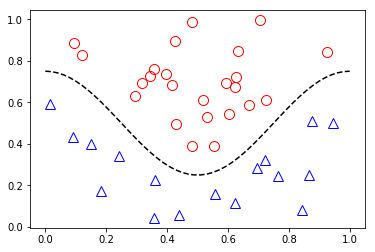

In [22]:
# gen_data.py
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 划分类别的边界
def cos_curve(x):
    return 0.25 * np.sin(2 * x * np.pi + 0.5 * np.pi) + 0.5

np.random.seed(123)

samples = []  # 保存二维点的坐标
labels = []   # 标明类别

sample_density = 50  # 单位空间内平均样本数
for i in range(sample_density):
    x1, x2 = np.random.random(2)
    
    # 计算当前 x1 对应的标签
    bound = cos_curve(x1)
    # 为了方便可视化，舍弃太靠近边界的样本
    if bound - 0.1 < x2 <= bound + 0.1:
        continue
    else:
        samples.append((x1, x2))
        if x2 > bound:
            labels.append(1)
        else:
            labels.append(0)

# 将生成的样本和标签保存
with open('data.pkl', 'wb') as f:
    pickle.dump((samples, labels), f)

# 可视化
for i, sample in enumerate(samples):
    plt.plot(sample[0], sample[1],
             'o' if labels[i] else '^',
             mec='r' if labels[i] else 'b',
             mfc='none',
             markersize=10)

x1 = np.linspace(0, 1)
plt.plot(x1, cos_curve(x1), 'k--')
plt.show()

In [1]:
import pickle
import logging
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Define the network
data = mx.sym.Variable('data')
fc1 = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=2)
sigmoid1 = mx.sym.Activation(data=fc1, name='sigmoid1', act_type='sigmoid')
fc2 = mx.sym.FullyConnected(data=sigmoid1, name='fc2', num_hidden=2)
mlp = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

# 网络结构可视化，基于 graphviz
shape = {'data': (2,)}
mlp_dot = mx.viz.plot_network(symbol=mlp, shape=shape)
mlp_dot.render('simple_mlp.gv', view=True)
#mx.viz.plot_network(mlp).view() 

'simple_mlp.gv.pdf'

C:\Anaconda3\envs\MXNet_Caffe\lib\site-packages\mxnet\model.py:984: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  optimizer=optimizer, initializer=initializer, **kwargs)
C:\Anaconda3\envs\MXNet_Caffe\lib\site-packages\mxnet\model.py:573: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.009
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.002
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.002
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.002
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.002
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.002
INFO:root:Epoch[6] Resetting Da

[[0.4130021 0.5869979]]


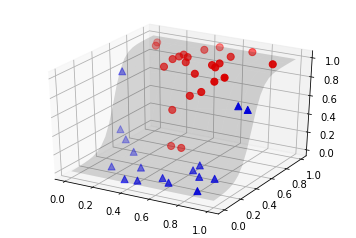

In [28]:
# Load data & train the model
with open('data.pkl', 'rb') as f:
    samples, labels = pickle.load(f)

logging.getLogger().setLevel(logging.DEBUG)

batch_size = len(labels)
samples = np.array(samples)
labels = np.array(labels)

train_iter = mx.io.NDArrayIter(samples, labels, batch_size)

model = mx.model.FeedForward.create(
    symbol=mlp,
    X=train_iter,
    num_epoch=1000,
    learning_rate=0.1,
    momentum=0.99)

'''
# Alternative interface to train the model
model = mx.model.FeedForward(
    symbol=mlp,
    num_epoch=1000,
    learning_rate=0.1,
    momentum=0.99)
model.fit(X=train_iter)
'''

print(model.predict(mx.nd.array([[0.5, 0.5]])))

# Visualize result
X = np.arange(0, 1.05, 0.05)
Y = np.arange(0, 1.05, 0.05)
X, Y = np.meshgrid(X, Y)

grids = mx.nd.array([[X[i][j], Y[i][j]] for i in range(X.shape[0]) for j in range(X.shape[1])])
grid_probs = model.predict(grids)[:, 1].reshape(X.shape)

fig = plt.figure('Sample Surface')
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, grid_probs, alpha=0.15, color='k', rstride=2, cstride=2, lw=0.5)
samples0 = samples[labels==0]
samples0_probs = model.predict(samples0)[:, 1]
samples1 = samples[labels==1]
samples1_probs = model.predict(samples1)[:, 1]

ax.scatter(samples0[:, 0], samples0[:, 1], samples0_probs, c='b', marker='^', s=50)
ax.scatter(samples1[:, 0], samples1[:, 1], samples1_probs, c='r', marker='o', s=50)

plt.show()